## Dependencies

In [ ]:
import pandas as pd
import numpy as np

# import os
# import random
# import cv2

import numpy as np
# from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
from os import path
sns.set()
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('ggplot')
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.linear_model import LogisticRegression
# from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
import datetime as dt
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import GridSearchCV
# import calendar
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.metrics.pairwise import cosine_similarity
# %matplotlib inline
# !pip install tensorflow
import time
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Dropout
from keras.layers import Conv1D, Flatten,MaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import auc

# Regular Expression for text cleaning
import re
# to track the progress - progress bar
from tqdm.notebook import tqdm

# My stuff
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout
from sklearn.utils import class_weight

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load data

Load already cleaned text.

In [ ]:
# Change:
# What CSVs to run based on model
# RoBERTa and BERT : cleaned_reddit_comments

df = pd.read_csv("/content/drive/MyDrive/Kaggle Club/SARCASM PROJECT '25/cleaned_reddit_comments.csv").fillna(' ')
df

,label,comment
0,0,nc and nh.
1,0,you do know west teams play against west teams...
2,0,"they were underdogs earlier today , but since ..."
3,0,"this meme is not funny none of the "" new york ..."
4,0,i could use one of those tools.
...,...,...
1010821,1,i am sure that iran and n. korea have the tech...
1010822,1,"whatever you do , do not vote green !"
1010823,1,perhaps this is an atheist conspiracy to make ...
1010824,1,the slavs got their own country - it is called...


## Dataset split
Training/Validation/Test : 80/10/10

Constant seed = 42

In [ ]:
strat = df['label']
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 42, stratify= strat)
strat = dummy_df['label']
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 42, stratify= strat)

print('Total dataset is ', df.shape)
print('Train shape is ' , train_df.shape)
print('Valid shape is ' , valid_df.shape)
print('Test shape is ' , test_df.shape)


Total dataset is  (1010826, 2)
Train shape is  (808660, 2)
Valid shape is  (101083, 2)
Test shape is  (101083, 2)


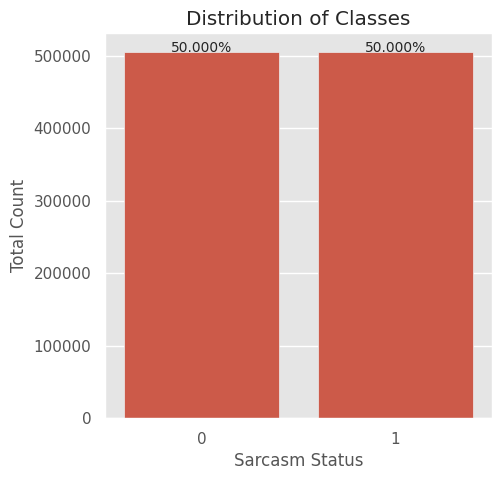

In [ ]:
plt.figure(figsize=(5,5))
ax = sns.countplot(x='label',  data= df)
ax.set(title = "Distribution of Classes", xlabel="Sarcasm Status", ylabel = "Total Count")
total = float(len(df ))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.3f}%'.format((height/total)*100),
            ha="center")
plt.show()

In [ ]:
# X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.3, random_state=42)
y_train = train_df['label']
y_test = test_df['label']
X_train = train_df['comment']
X_test = test_df['comment']

## Tokenization + embedding

In [ ]:
# copied from github
MAX_LENGTH = 256  # Set the maximum sequence length for BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

X_train_encoded = tokenizer.batch_encode_plus(
    X_train.tolist(),
    add_special_tokens=True,
    max_length=MAX_LENGTH,
    return_attention_mask=True,
    return_tensors='tf',
    pad_to_max_length=True,
    truncation=True
)
X_test_encoded = tokenizer.batch_encode_plus(
    X_test.tolist(),
    add_special_tokens=True,
    max_length=MAX_LENGTH,
    return_attention_mask=True,
    return_tensors='tf',
    pad_to_max_length=True,
    truncation=True
)

# Define class weights for handling imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


## Model

In [ ]:
MAX_NUM_WORDS = len(tokenizer.get_vocab())

In [ ]:
EMBEDDING_DIM = 128  # Word embedding size
LSTM_UNITS = 128

input_layer = Input(shape=(MAX_LENGTH,))
embedding_layer = Embedding(input_dim=MAX_NUM_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_LENGTH)(input_layer)
bi_lstm_layer = Bidirectional(LSTM(LSTM_UNITS))(embedding_layer)
dropout_layer = Dropout(0.5)(bi_lstm_layer)
output_layer = Dense(1, activation='sigmoid')(dropout_layer)

bi_lstm_model = Model(inputs=input_layer, outputs=output_layer)

# Compile the Bi-LSTM model
bi_lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the Bi-LSTM model
hist = bi_lstm_model.fit(X_train_encoded['input_ids'], y_train, epochs=2, batch_size=64, class_weight=class_weight_dict)

# Train the Bi-LSTM model later

# Evaluate the Bi-LSTM model
bi_lstm_loss, bi_lstm_accuracy = bi_lstm_model.evaluate(X_test_encoded['input_ids'], y_test)

print("Bi-LSTM Model - Loss:", bi_lstm_loss)
print("Bi-LSTM Model - Accuracy:", bi_lstm_accuracy)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/2
12636/12636 ━━━━━━━━━━━━━━━━━━━━ 366s 28ms/step - accuracy: 0.7017 - loss: 0.5671
Epoch 2/2
12636/12636 ━━━━━━━━━━━━━━━━━━━━ 359s 28ms/step - accuracy: 0.7554 - loss: 0.4984
3159/3159 ━━━━━━━━━━━━━━━━━━━━ 30s 9ms/step - accuracy: 0.7389 - loss: 0.5191
Bi-LSTM Model - Loss: 0.516722559928894
Bi-LSTM Model - Accuracy: 0.7413412928581238


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

class_names = [str(i) for i in range(len(np.unique(y_test)))]
y_pred = bi_lstm_model.predict(X_test_encoded['input_ids']) # Convert the predicted probabilities to class labels
y_pred_labels = (y_pred > 0.5).astype(int) # Get the true class labels from the test data generator

if len(y_test.shape) == 2:
    y_true_labels = np.argmax(y_test, axis=1)  # Convert one-hot to class indices
else:
    y_true_labels = y_test  # Already class labels

accuracy = accuracy_score(y_test, y_pred_labels)
print("Testing Accuracy:", accuracy)
f1 = f1_score(y_test, y_pred_labels)
print("Testing F1 Score:", f1)
print("The Accuracy is",accuracy_score(y_test,y_pred_labels))

3159/3159 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step
Testing Accuracy: 0.7413412740025523
Testing F1 Score: 0.728764679032325
The Accuracy is 0.7413412740025523


In [ ]:
report = classification_report(y_true_labels, y_pred_labels, target_names=class_names, digits=4)
print("Classification Report: ")
print( report)

Classification Report: 
              precision    recall  f1-score   support

           0     0.7209    0.7877    0.7528     50542
           1     0.7660    0.6950    0.7288     50541

    accuracy                         0.7413    101083
   macro avg     0.7434    0.7413    0.7408    101083
weighted avg     0.7434    0.7413    0.7408    101083



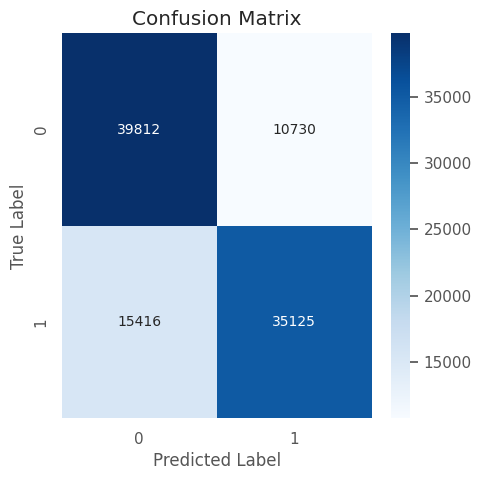

In [ ]:

confusion_mtx = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_mtx, cmap="Blues", annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()
plot_training(hist)


KeyError: 'val_accuracy'